# TRAIN CNN MODEL FOR OCR_Part1

I prepare this notebook to show 'how to train a custom Keras model to recognize digits and letters'. The other notebooks in my repo about OCR, I used library and pretrained model to detect and recognize letters. Now I will train a model with a custom dataset which includes letters and digits. I used the blog of Adrian Rosebrock (https://pyimagesearch.com/2020/08/17/ocr-with-keras-tensorflow-and-deep-learning/?_ga=2.231299551.137545911.1655435468-1130789896.1638882117) as a main reference. At the end of the notebook, I will use this model for handwritten letter recognition. You can see the reference links at the end of notebook. 

For this purpose , I will use two datasets. One of them is standard MNIST dataset, you can load easily by tensorflow. The second one is the Kaggle A-Z dataset by Sachin Patel.The second dataset is based on the NIST Special Database 19, but Patel converted letters(A-Z) to a csv file. We will combine these two datasets and prepare our dataset for model training. 

First, we need to load our data. As I mentioned above, we need two datasets but they should be one dataset for training. Because of that reason, we need functions to take datasets and convert them to same shape to combine in a one dataset.

Let's begin wtih these functions...

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
import numpy as np

'load_az_dataaset()' is a function to load Patel's dataset from csv file. Each row's first column is 'label' and the other columns are the values of the 784(28x28)pixels of letters. Because of that, we will take the 784 columns and reshape them 28x28 array to create data. 

In [2]:
def load_az_dataset(datasetPath):
    # initialize two lists for data and labels
    data = []
    labels = []

    # we need loop over the rows of the A-Z digit dataset
    #If you open the csv file, you will see first column is label, the other 784 columns are for pixel values
    for row in open(datasetPath):
        # parse the label and image from the row
        row = row.split(",")
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")

        # images are represented as single channel (grayscale) images
        # that are 28x28=784 pixels -- we need to take this flattened
        # 784-d list of numbers and repshape them into a 28x28 matrix
        image = image.reshape((28, 28))

        # update the list of data and labels
        data.append(image)
        labels.append(label)

    # convert the list of data and labels to NumPy arrays
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")

    # return a 2-tuple of the A-Z data and labels
    return (data, labels)

In [3]:
#load our A-Z dataset
(az_Data, az_Labels) = load_az_dataset('a_z_handwritten_data.csv')

Let's check the dimensions...

In [4]:
print(np.shape(az_Data))

(372451, 28, 28)


In [5]:
print(np.shape(az_Labels))

(372451,)


Let's check the first value of dataset and its label

In [6]:
print(az_Data[0])

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   32. 215. 235.  43.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  130. 255. 255. 107.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  14.
  227. 255. 255. 107.   0.   0.   0.   0.   0.   0.   0.  

In [7]:
print(az_Labels[0])

0


The letter “A” has a label corresponding to the integer “0” and the letter “Z” has an integer label value of “25”.

I think the array of first data doesn't mean something . For a good visualization let's see what it is by two methods.

In [8]:
import cv2
NumpyArray = np.array(az_Data[0])
cv2.imshow('first_data', NumpyArray)
cv2.waitKey()

-1

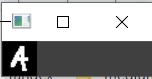



OR



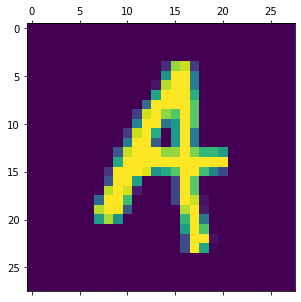

In [9]:
import matplotlib.pyplot as plt
plt.matshow(NumpyArray)

We loaded our A-Z dataset into 2 tuples (az_Data, az_Labels). You can use these two methods to see the data and labels.

Now it is time for loading the MNIST Dataset. For this purpose , Adrian again prepare a nice function.

In [10]:
def load_mnist_dataset():
# load the MNIST dataset and stack the training data and testing
# data together (we'll create our own training and testing splits
# later in the project)
    ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabels, testLabels])

    # return a 2-tuple of the MNIST data and labels
    return (data, labels)

In [11]:
(digitsData, digitsLabels) = load_mnist_dataset()

In [12]:
print(np.shape(digitsData))

(70000, 28, 28)


In [13]:
print(np.shape(digitsLabels))

(70000,)


So we have 2 tuple for the labels and 2 tuple for data. We should combine them in one. The dimensions of data tuples are same if you print the shapes. But if you remember, A-Z dataset labels begin with 0 like the MNIST dataset. To solve this problem, we will add '10' to every label in the 'az_Labels'. Then we are ready to merge them.

In [14]:
print(az_Labels[:20])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [15]:
az_Labels += 10

In [16]:
print(az_Labels[:20])

[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


In [17]:
# merge the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([az_Data, digitsData])
labels = np.hstack([az_Labels, digitsLabels])

In [18]:
print(np.shape(data))

(442451, 28, 28)


In [19]:
print(np.shape(labels))

(442451,)


Until now, we understood our dataset and loaded them. We need some preprocess in our 'data' tuple. To understand this need, let's see what our model looks like.

When you check the ResNet.py file, You can see the parameter of methods. In this file, A CNN architecture is prepared. If you are not familiar about CNN,ResNet,TF models; This file makes no sense. The explanation for ResNet or preparation of a CNN in Keras is out of scope for this notebook.

If the ResNet.py is not frightening for you , You can see the proper dimensions of data for CNN.For this reason, we need to reshape our 'data' to 32x32 from 28x28.

In [20]:
data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

In [21]:
print(np.shape(data))

(442451, 32, 32)


In [22]:
# add a channel dimension to every image in the dataset for model structure
data = np.expand_dims(data, axis=-1)


In [23]:
print(np.shape(data))

(442451, 32, 32, 1)


In [24]:
# scale pixel intensities of the images from [0, 255] down to [0, 1]
data /= 255.0

For using labels in the training, we need to change them vectors from integer. For this purpose, we will use the LabelBinarizer function 

In [25]:
from sklearn.preprocessing import LabelBinarizer
le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)

In [26]:
#to know 'how many example' for each label
print(counts)

[ 6903  7877  6990  7141  6824  6313  6876  7293  6825  6958 13870  8668
 23409 10134 11440  1163  5762  7218  1120  8493  5603 11586 12336 19010
 57825 19341  5812 11566 48419 22495 29008  4182 10784  6272 10859  6076]


In [27]:
# 10 digits and 26 letters
print(np.shape(labels))

(442451, 36)


As you can see, there is a big difference between the number of image for each label. For that reason, we need 'classWeight' list while training.

In [28]:
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]


In [29]:
print(classWeight)

{0: 8.376792698826597, 1: 7.340992763742541, 2: 8.272532188841202, 3: 8.097605377398123, 4: 8.473769050410317, 5: 9.15967052114684, 6: 8.409685863874346, 7: 7.928835870012341, 8: 8.472527472527473, 9: 8.310577752227651, 10: 4.169069935111752, 11: 6.671089063221043, 12: 2.4702037677816224, 13: 5.7060390763765545, 14: 5.0546328671328675, 15: 49.72055030094583, 16: 10.035577924331829, 17: 8.011221945137157, 18: 51.629464285714285, 19: 6.808548216178029, 20: 10.320364090665715, 21: 4.990937338166753, 22: 4.6875, 23: 3.0418200946870066, 24: 1.0, 25: 2.989762680316426, 26: 9.94924294562973, 27: 4.999567698426422, 28: 1.1942625828703608, 29: 2.5705712380529007, 30: 1.993415609487038, 31: 13.827116212338593, 32: 5.362110534124629, 33: 9.21954719387755, 34: 5.3250759738465785, 35: 9.51695194206715}



While training a machine learning or deep learning model, the dataset should be divided two for test and train. If you have question about that concept, you should check ML basics. For spliting the dataset, we will use 'train_test_split' method from sklearn library. We only need to define the percentage for test , and method will divide dataset for us.


In [30]:
from sklearn.model_selection import train_test_split
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.20, stratify=labels, random_state=42)

In [31]:
print(np.shape(trainX))
print(np.shape(testX))
print(np.shape(trainY))
print(np.shape(testY))

(353960, 32, 32, 1)
(88491, 32, 32, 1)
(353960, 36)
(88491, 36)



The image augmentation technique is a great way to expand the size of your dataset. When you need more images, you can use this method. ImageDataGenerator is out of scope for this notebook, but I added a blog post link at the reference if you want to look.


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=10,zoom_range=0.05,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.15,
horizontal_flip=False,fill_mode="nearest")

In [33]:
from tensorflow.keras.optimizers import SGD
from models import ResNet
import matplotlib
from sklearn.metrics import classification_report

In [34]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 50
INIT_LR = 1e-1
BS = 128
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


[INFO] compiling model...


C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [35]:
# train the network
print("[INFO] training network...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY),steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS,class_weight=classWeight,verbose=1)

[INFO] training network...
Epoch 1/50
 125/2765 [>.............................] - ETA: 38:38 - loss: 11.6917 - accuracy: 0.3273

KeyboardInterrupt: 


BUT, WAIT.... If you try to train this network on CPU, it may take 2 days... The main purpose is to show you how it works... So I will change the Epoch size and train a model to show results. The results will be bad . If you need a successful model, you need to train this network with a reasonable epoch size.

Again , I need to compile model with different hyperparameters.

In [37]:
EPOCHS = 1
INIT_LR = 1e-1
BS = 128
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])


[INFO] compiling model...



And Train...



In [38]:
# train the network
print("[INFO] training network...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY),steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS,class_weight=classWeight,verbose=1)

[INFO] training network...
2765/2765 [==============================] - 2682s 969ms/step - loss: 9.1982 - accuracy: 0.5860 - val_loss: 1.6503 - val_accuracy: 0.7522



We trained our model and It is time to check results.

We need a map for our labels. As you remember, Our labels are numbers from 0 to 36. When our model makes a prediction, It returns the index of label. We need to convert a proper result to understand prediction. Because of that, we need a map.


In [39]:
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]



Now it is time to see what our model 'learned' from training. For that purpose we use our test data. With the help of sklearn, we can print result by 'classification_report'.



In [40]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BS)
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
              precision    recall  f1-score   support

           0       0.20      0.28      0.24      1381
           1       0.72      0.94      0.82      1575
           2       0.59      0.59      0.59      1398
           3       0.63      0.95      0.76      1428
           4       0.70      0.51      0.59      1365
           5       0.41      0.66      0.51      1263
           6       0.71      0.60      0.65      1375
           7       0.69      0.85      0.76      1459
           8       0.58      0.80      0.68      1365
           9       0.54      0.88      0.67      1392
           A       0.85      0.63      0.72      2774
           B       0.74      0.77      0.75      1734
           C       0.88      0.80      0.84      4682
           D       0.66      0.58      0.62      2027
           E       0.88      0.93      0.90      2288
           F       0.68      0.98      0.80       232
           G       0.54      0.70      0.61      115



I spent 40 minutes for this bad model, so I don't want to lose it. I will use this model to predict handwritten. I need to save this.

In [41]:
# save the model to disk
print("[INFO] serializing network...")
model.save('one_epoch_resnet.model', save_format="h5")

[INFO] serializing network...


C:\Users\Zeki\anaconda3\envs\githubtf\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)




Our model is not a good example for a history plot because we only trained 1 epoch , but I want to show 'how we draw loss graphs and save it'.



In [43]:
from imutils import build_montages
import matplotlib.pyplot as plt

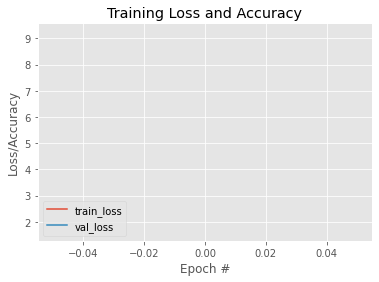

In [47]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('plot_of_history.png')


The next code block is for showing some of predictions on test dataset.Thanks to Adrian again. We will choose random images and will write 'what our model predicts' on this images. The block is good example of using opencv and visualization of predictions.



In [ ]:
# initialize our list of output images
images = []

# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
# classify the character
    probs = model.predict(testX[np.newaxis, i])
    prediction = probs.argmax(axis=1)
    label = labelNames[prediction[0]]

    # extract the image from the test data and initialize the text
    # label color as green (correct)
    image = (testX[i] * 255).astype("uint8")
    color = (0, 255, 0)

    # otherwise, the class label prediction is incorrect
    if prediction[0] != np.argmax(testY[i]):
        color = (0, 0, 255)

    # merge the channels into one image, resize the image from 32x32
    # to 96x96 so we can better see it and then draw the predicted
    # label on the image
    image = cv2.merge([image] * 3)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,color, 2)

    # add the image to our list of output images
    images.append(image)

# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]

# show the output montage
cv2.imshow("OCR Results", montage)
cv2.waitKey(0)

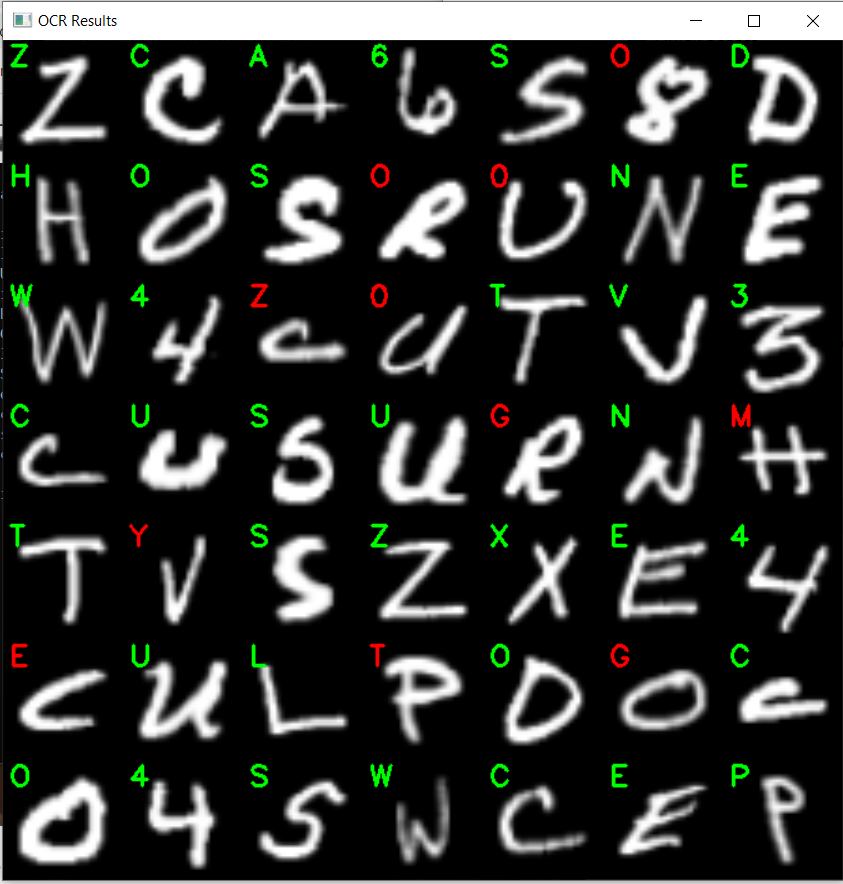


I have to admit the results are better than my expectation.

In this notebook, we trained a deep learning CNN model for digit and letter recognition. We used a custom dataset and trained our CNN model. 

Next notebook, I will use this model to detect letters in images. I hope the notebook gives basic idea about 'training a CNN model'.


REFERENCE LINKS:

* http://yann.lecun.com/exdb/mnist/

* https://pyimagesearch.com/2020/08/17/ocr-with-keras-tensorflow-and-deep-learning/?_ga=2.110427078.2138365318.1655895679-1130789896.1638882117

* https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/